# 1. 환경설정 및 데이터 업로드 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
train = pd.read_csv('./data/train_df.csv', engine='python',encoding='CP949')
test = pd.read_csv('./data/test_df.csv', engine='python',encoding='CP949')

# 불필요한 변수 제거
train.drop('index', axis=1 ,inplace= True)
test.drop('index', axis=1 ,inplace= True)
submission = pd.read_csv('./data/sample_submission.csv', engine='python',encoding='CP949')
print(train.shape, test.shape, submission.shape)

(32000, 5) (4640, 4) (4640, 2)


# 2. 데이터 전처리

#### 2.1) 고유격자번호와 상품 카테고리를 Feature engineering 실시

In [3]:
# 시군구 코드(시 2가지, 군구 3가지)
def trans_INNB(data):
    df = data.copy()
    
    # 고유번호 5자리는 시군구로 확인, 이를 이용하여 전처리 시행
    df['SEND_SPG_INNB'] = df['SEND_SPG_INNB'].astype('str')
    df['REC_SPG_INNB'] = df['REC_SPG_INNB'].astype('str')
    
    df['SEND_1'] = df['SEND_SPG_INNB'].apply(lambda x : x[:2])
    df['SEND_2'] = df['SEND_SPG_INNB'].apply(lambda x : x[2:5])
    
    df['REC_1'] = df['REC_SPG_INNB'].apply(lambda x : x[:2])
    df['REC_2'] = df['REC_SPG_INNB'].apply(lambda x : x[2:5])

    
    ## ID 생성: 각 컬럼의 값들을 더해서 고유한 물류 이동으로 가정
    df['ID_category'] = \
    df['DL_GD_LCLS_NM'].astype(str) + '_' + df['DL_GD_MCLS_NM'].astype(str)
    
    df['ID_1'] = \
    df['SEND_SPG_INNB'].astype(str) + '_' + df['REC_SPG_INNB'].astype(str) 
    
    df['ID_2'] = \
    df['SEND_1'].astype(str) + '_' + df['REC_1'].astype(str) 
    
    df['ID_3'] = \
    df['SEND_1'].astype(str) + df['SEND_2'].astype('str') + '_' + df['REC_1'].astype(str) + df['REC_2'].astype(str) 
    
    return df

train = trans_INNB(train)
test = trans_INNB(test)

In [4]:
train.head()

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,SEND_1,SEND_2,REC_1,REC_2,ID_category,ID_1,ID_2,ID_3
0,1129000014045300,5011000220046300,패션의류,상의,3,11,290,50,110,패션의류_상의,1129000014045300_501100022...,11_50,11290_50110
1,1135000009051200,5011000178037300,생활/건강,반려동물,3,11,350,50,110,생활/건강_반려동물,1135000009051200_501100017...,11_50,11350_50110
2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,11,350,50,110,패션의류_기타패션의류,1135000030093100_501100026...,11_50,11350_50110
3,1154500002014200,5011000315087400,식품,농산물,10,11,545,50,110,식품_농산물,1154500002014200_501100031...,11_50,11545_50110
4,1165000021008300,5011000177051200,식품,가공식품,3,11,650,50,110,식품_가공식품,1165000021008300_501100017...,11_50,11650_50110


#### 2.2) Category 변수를 Count embedding로 전환

In [5]:
# Count embedding
def trans_ratio_ver(df):
    trans_ratio = ['SEND_SPG_INNB', 'REC_SPG_INNB', 'SEND_1', 'REC_1', 'ID_category', 'ID_1', 'ID_2', 'ID_3']

    for i,j in enumerate(trans_ratio):
        cluster_count=df.groupby(j).count()
        cluster_sum=sum(cluster_count.DL_GD_LCLS_NM)
        cluster_count.ratio = cluster_count.DL_GD_LCLS_NM

        dic = cluster_count.ratio.to_dict()

        name = j + '_COUNT'
        df[name] = df[j].map(lambda x: dic[x])
        
    return df
    
train = trans_ratio_ver(train)
test = trans_ratio_ver(test)

In [6]:
# 불필요한 변수 삭제
cols = ['SEND_SPG_INNB', 'REC_SPG_INNB', 'SEND_1', 'SEND_2', 'REC_1', 'REC_2', 'ID_category', 'ID_1', 'ID_2', 'ID_3']

train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)
train.head()

,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,SEND_SPG_INNB_COUNT,REC_SPG_INNB_COUNT,SEND_1_COUNT,REC_1_COUNT,ID_category_COUNT,ID_1_COUNT,ID_2_COUNT,ID_3_COUNT
0,패션의류,상의,3,67,2,859,6833,321,1,859,59
1,생활/건강,반려동물,3,27,1,859,6833,358,1,859,30
2,패션의류,기타패션의류,9,2,1,859,6833,261,1,859,30
3,식품,농산물,10,1,10,859,6833,22162,1,859,20
4,식품,가공식품,3,1,2,859,6833,923,1,859,52


#### 2.3) 스케일링(log, minmax) 적용

In [7]:
def MINMAX_SC(data):
    df = data.copy()
    try:
        # skew가 1이 넘는 변수에 대해 log 변환
        skewness = df.drop(['INVC_CONT','DL_GD_LCLS_NM','DL_GD_MCLS_NM'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
        skew_feats = skewness[skewness>1].index
        print('로그(Log)변환을 적용할 변수명 : ', skew_feats.to_list())

        df[skew_feats] = np.log1p(df[skew_feats])
        
                # Minmax scaler 적용
        numerical_feats = df.dtypes[df.dtypes != 'object'].index.tolist()
        numerical_feats.remove('INVC_CONT')
        df[numerical_feats] = MinMaxScaler().fit_transform(df[numerical_feats])
        
    except:
        skewness = df.drop(['DL_GD_LCLS_NM','DL_GD_MCLS_NM'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
        skew_feats = skewness[skewness>1].index
        print('로그(Log)변환을 적용할 변수명 : ', skew_feats.to_list())

        df[skew_feats] = np.log1p(df[skew_feats])
        
        # Minmax scaler 적용
        numerical_feats = df.dtypes[df.dtypes != 'object'].index.tolist()
        df[numerical_feats] = MinMaxScaler().fit_transform(df[numerical_feats])

    
    return df
train = MINMAX_SC(train)
test = MINMAX_SC(test)

로그(Log)변환을 적용할 변수명 :  ['ID_1_COUNT', 'REC_SPG_INNB_COUNT', 'ID_3_COUNT', 'SEND_SPG_INNB_COUNT']
로그(Log)변환을 적용할 변수명 :  ['ID_1_COUNT', 'REC_SPG_INNB_COUNT', 'ID_3_COUNT', 'SEND_SPG_INNB_COUNT']


#### 2.4) 상관계수 확인

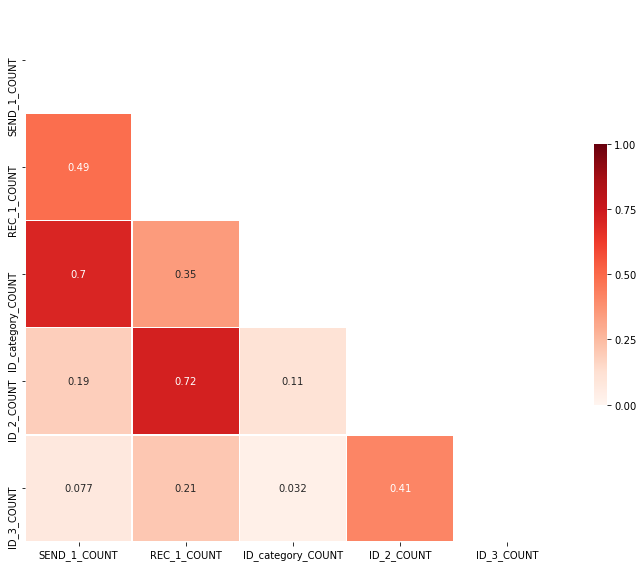

In [8]:
# 상관계수 데이터 불러오기
cor_data = train.copy()
cor_data.drop(['INVC_CONT'], axis = 1, inplace = True)

# 절대값 기준으로 상관계수 검정
corr_matrix = cor_data.corr().abs()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# 0.8 강한 상관계수 값을 보이는 변수들만 추출
corr_rel_check = (corr_matrix > 0.4).sum()-1 
corr_remove = pd.DataFrame(corr_rel_check[corr_rel_check > 0]).T

# 상관계수 다시 생성
corr_remove = cor_data[corr_remove.columns.to_list()].corr().abs()
mask = np.zeros_like(corr_remove, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_remove,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds', #
                      cbar_kws = {'shrink': .4,
                                'ticks' : [0 , 0.25, 0.5, 0.75 , 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True
                     )
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# 3. 모델링(Catboost, LGBM)

In [13]:
# 평가지표 RMSE 설정
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Fold 수 선정, 종속변수 확인
n_fold = 5
target = 'INVC_CONT'

#### 3.1) Catboost

In [14]:
# 데이터 분할
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0]))
cat_pred_test = np.zeros((X_test.shape[0]))
cat_cols = ['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold+1} -----------------\n')

    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)


    model_cat = CatBoostRegressor(random_state = 84)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, 
                  early_stopping_rounds=100, 
                  verbose=100)
  
    cat_pred[valid_idx] = model_cat.predict(X_valid)
    cat_pred_test += model_cat.predict(X_test) / n_fold
    print(f'CV RMSE Score: {RMSE(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t RMSE: {RMSE(y, cat_pred):.6f}')


----------------- Fold 1 -----------------

Learning rate set to 0.086959
0:	learn: 5.6098081	test: 6.7708175	best: 6.7708175 (0)	total: 36.1ms	remaining: 36.1s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 5.0840352	test: 6.1620857	best: 6.1620857 (100)	total: 3.79s	remaining: 33.8s
200:	learn: 4.9844722	test: 6.0584315	best: 6.0582821 (197)	total: 7.3s	remaining: 29s
300:	learn: 4.8850807	test: 5.9580005	best: 5.9577885 (287)	total: 10.9s	remaining: 25.3s
400:	learn: 4.8155791	test: 5.9382055	best: 5.9368390 (380)	total: 14.4s	remaining: 21.6s
500:	learn: 4.7504001	test: 5.8846277	best: 5.8846277 (500)	total: 18s	remaining: 17.9s
600:	learn: 4.6913387	test: 5.8807930	best: 5.8786350 (576)	total: 21.6s	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.878635
bestIteration = 576

Shrink model to first 577 iterations.
CV RMSE Score: 5.878635

----------------- Fold 2 -----------------

Learning rate set to 0.086959
0:	learn: 5.7858027	test: 5.2825344	best: 5.2825344 (0)	total: 38.2ms	remaining: 38.2s
100:	learn: 5.2434283	test: 5.1777197	best: 5.1774540 (99)	total: 3.45s	remaining: 30.7s
200:	learn: 5.0638136	test: 5.1565810	best: 5.1547529 (

In [15]:
# 1차 CV  RMSE: 5.635174
# 2차 CV  RMSE: 5.412020
# 3차 CV  RMSE: 5.369225
# 4차 CV  RMSE: 5.274312
# 5차 CV  RMSE: 5.270921
# 6차 CV  RMSE: 5.222735
print(cat_pred_test)

# 저장
submission['INVC_CONT']  = cat_pred_test
submission.to_csv('Catboost_count.csv',index = False)

[4.85703009 5.15118309 5.252598   ... 5.53593046 5.18338251 5.80589704]


#### 3.2) 변수 중요도 확인

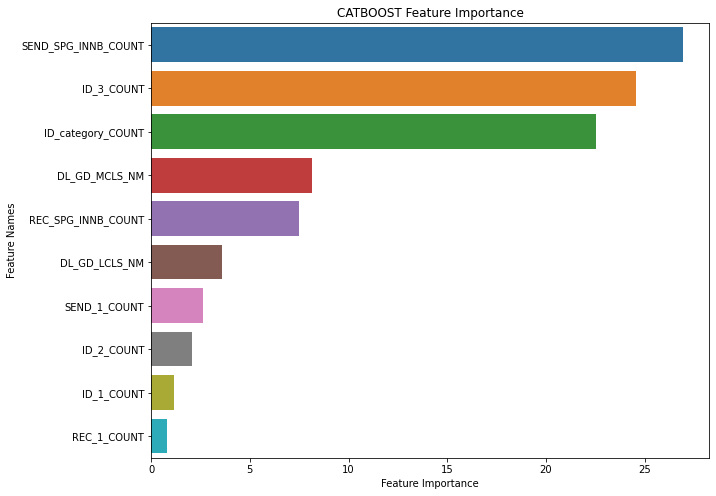

In [16]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

#### 3.3) 모델링(Baseline, LightGBM)

In [17]:
train = pd.read_csv('./data/train_df.csv', engine='python',encoding='CP949')
test = pd.read_csv('./data/test_df.csv', engine='python',encoding='CP949')

# 불필요한 변수 제거
train.drop('index', axis=1 ,inplace= True)
test.drop('index', axis=1 ,inplace= True)
submission = pd.read_csv('./data/sample_submission.csv', engine='python',encoding='CP949')
print(train.shape, test.shape, submission.shape)

(32000, 5) (4640, 4) (4640, 2)


In [18]:
from lightgbm import LGBMRegressor

train_one = pd.get_dummies(train)
test_one = pd.get_dummies(test)
print(train_one.shape, test_one.shape)

train_X = train_one.drop('INVC_CONT',axis = 1)
train_Y = train_one['INVC_CONT']
#모델 정의
model = LGBMRegressor(random_state = 84)
model.fit(train_X,train_Y)
pred = model.predict(test_one)
submission['INVC_CONT'] = pred

(32000, 29) (4640, 28)


In [19]:
print(submission['INVC_CONT'])
submission.to_csv('LGB_count_only.csv',index = False)

0      4.59435
1      6.09149
2      4.03826
3      4.54464
4      4.12210
         ...  
4635   5.15585
4636   4.43762
4637   4.70186
4638   4.39281
4639   4.41670
Name: INVC_CONT, Length: 4640, dtype: float64


# 4. 사용하지 않은 코드

#### 1) 카테고리 별 종속변수의 평균 값, Data Leakage 예상

In [ ]:
# 고유 아이디
ID_INNB_df = train.groupby('ID_INNB',as_index = False)['INVC_CONT'].mean()
ID_INNB_df.rename(columns = {'INVC_CONT' : 'ID_INNB_mean'}, inplace = True)

# 카테고리
ID_category_df = train.groupby('ID_category',as_index = False)['INVC_CONT'].mean()
ID_category_df.rename(columns = {'INVC_CONT' : 'ID_category_mean'}, inplace = True)

# 병합
train = pd.merge(train, ID_INNB_df, how = 'left')
train = pd.merge(train, ID_category_df, how = 'left')

# 병합
test = pd.merge(test, ID_INNB_df, how = 'left')
test = pd.merge(test, ID_category_df, how = 'left')
test.fillna(0, inplace = True)

def outlier(data):
    df = data.copy()
    df.loc[df['ID_INNB_mean'] > 10, 'ID_INNB_mean'] = 1
    df['ID_INNB_mean'] = df['ID_INNB_mean'].apply(lambda x : 0 if x != 1 else 1)
    return df

train = outlier(train)
test = outlier(test)

#### 2) 클러스터링 구성을 통한 새로운 변수 도출

In [ ]:
from sklearn.cluster import KMeans

# 클러스터링 구성 : 
kmeans_train = train_one.drop(['INVC_CONT'], axis=1)
kmeans = KMeans(n_clusters=10, random_state=42).fit(kmeans_train)
train_one['cluster'] = kmeans.predict(kmeans_train)
test_one['cluster'] = kmeans.predict(test_one)

#### 3) Pycaret AutoML

In [ ]:
from pycaret.datasets import get_data 
from pycaret.classification import *
from pycaret.utils import check_metric
# https://minimin2.tistory.com/137


# dataset 생성
dataset = get_data('juice')

# setup으로 init
clf = setup(data=dataset, target='Purchase')

# ML 모델 성능 비교
top5 = compare_models(sort='Accuracy', n_select=5)
# 모델 튜닝, blending
tuned_top5 = [tune_model(i) for i in top5]
blender_top5 = blend_models(estimator_list=tuned_top5)

# 모델 최종 확정, 전체 데이터 학습
final_model = finalize_model(blender_top5)
# 테스트셋 predict
prediction = predict_model(final_model, data=dataset.iloc[-100:])

# metric 확인
check_metric(prediction['Purchase'], prediction['Label'], metric = 'Accuracy')